### CU Boulder MSCS Machine Learning Course 1 Final Project:

For my final project I will be cleaning, analyzing, and building models for a predictive maintenance dataset. My goal will be to evaluate different classification models in order to build a model to correctly classify if a part is expected to have failed. 

#### Data Used:
I am utilizing a dataset provided by UC Irvine via kaggle [linked here.](https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification)

Citation (APA Format): AI4I 2020 Predictive Maintenance Dataset [Dataset]. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5HS5C.


#### Motivation:
This area of focus is interesting to me because I currently work as a test engineer. I've been interested in trying to use the data I collect during my tests to predict failures are degredation of performance for the machines I work with. I haven't, until this point, had the knowledge required for that. I look forward to using the techniques profesionally after finishing this course.

#### Model Building 

The models I found most interesting during class were the ensemble tree models so I will be trying both a Random Forest Classifier, Adaboost Classifier, and also a Gradient Boosting Classifier. I've read that Gradient Boosting is supposed to deliver a very high performing boosted decision tree model and I want to try it here.  I will iterate through the models to tune the hyperparameters and try to get the best performing results possible. Decision tree based models do not need data normalization during preprocessing so I will be bypassing that step.

#### Goal:

**Primary:** To build a classifier model that can predict machine failures to a high enough level of accuracy to provide business utility.

**Secondary:** Create the documented process and infrastructure to retrain the model as new data becomes present. The real world has a way of shifting out from under a model, and in order to maintain high degrees of utility, models often have to be retrained with updated data and assumptions. 

In [69]:
# Import the base tools
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV





# load the csv, dataset will be provided in the repo
maintenance_df = pd.read_csv("predictive_maintenance.csv")

### Dataset Overview and cleaning:

The dataset contains a number of numeric and categorical columns. In order to clean this dataset for further use, I am going to drop all columns with the Dtype object. They are ancicliary pieces of information that will not be considered at this point. The focus of this analysis will be to predict outcome based on numeric data. I will also take a number of cleaning steps based on the outcome of the correlation analysis below. I am also droping the UDI column as it is just a unique identifier for each machine that will contribute significant noise if it is allowed into the model.

In [85]:
# Do a quick vibe check of the data to see what we've got to work with
maintenance_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


                         Air temperature [K]  Process temperature [K]  \
Air temperature [K]                 1.000000                 0.876107   
Process temperature [K]             0.876107                 1.000000   
Rotational speed [rpm]              0.022670                 0.019277   
Torque [Nm]                        -0.013778                -0.014061   
Tool wear [min]                     0.013853                 0.013488   

                         Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  
Air temperature [K]                    0.022670    -0.013778         0.013853  
Process temperature [K]                0.019277    -0.014061         0.013488  
Rotational speed [rpm]                 1.000000    -0.875027         0.000223  
Torque [Nm]                           -0.875027     1.000000        -0.003093  
Tool wear [min]                        0.000223    -0.003093         1.000000  


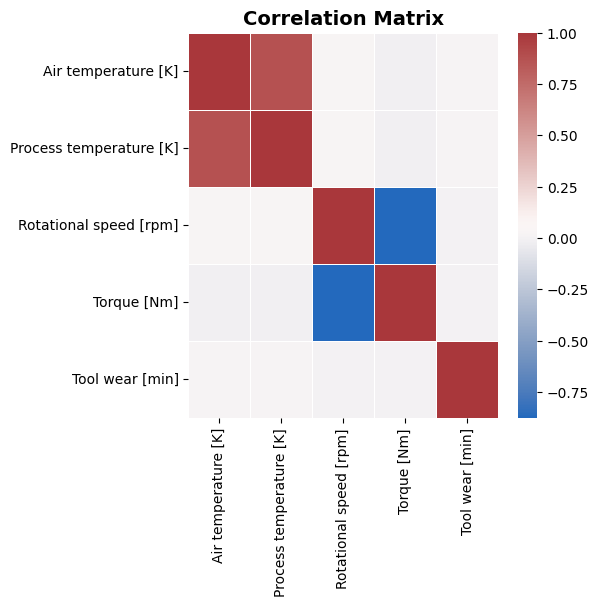

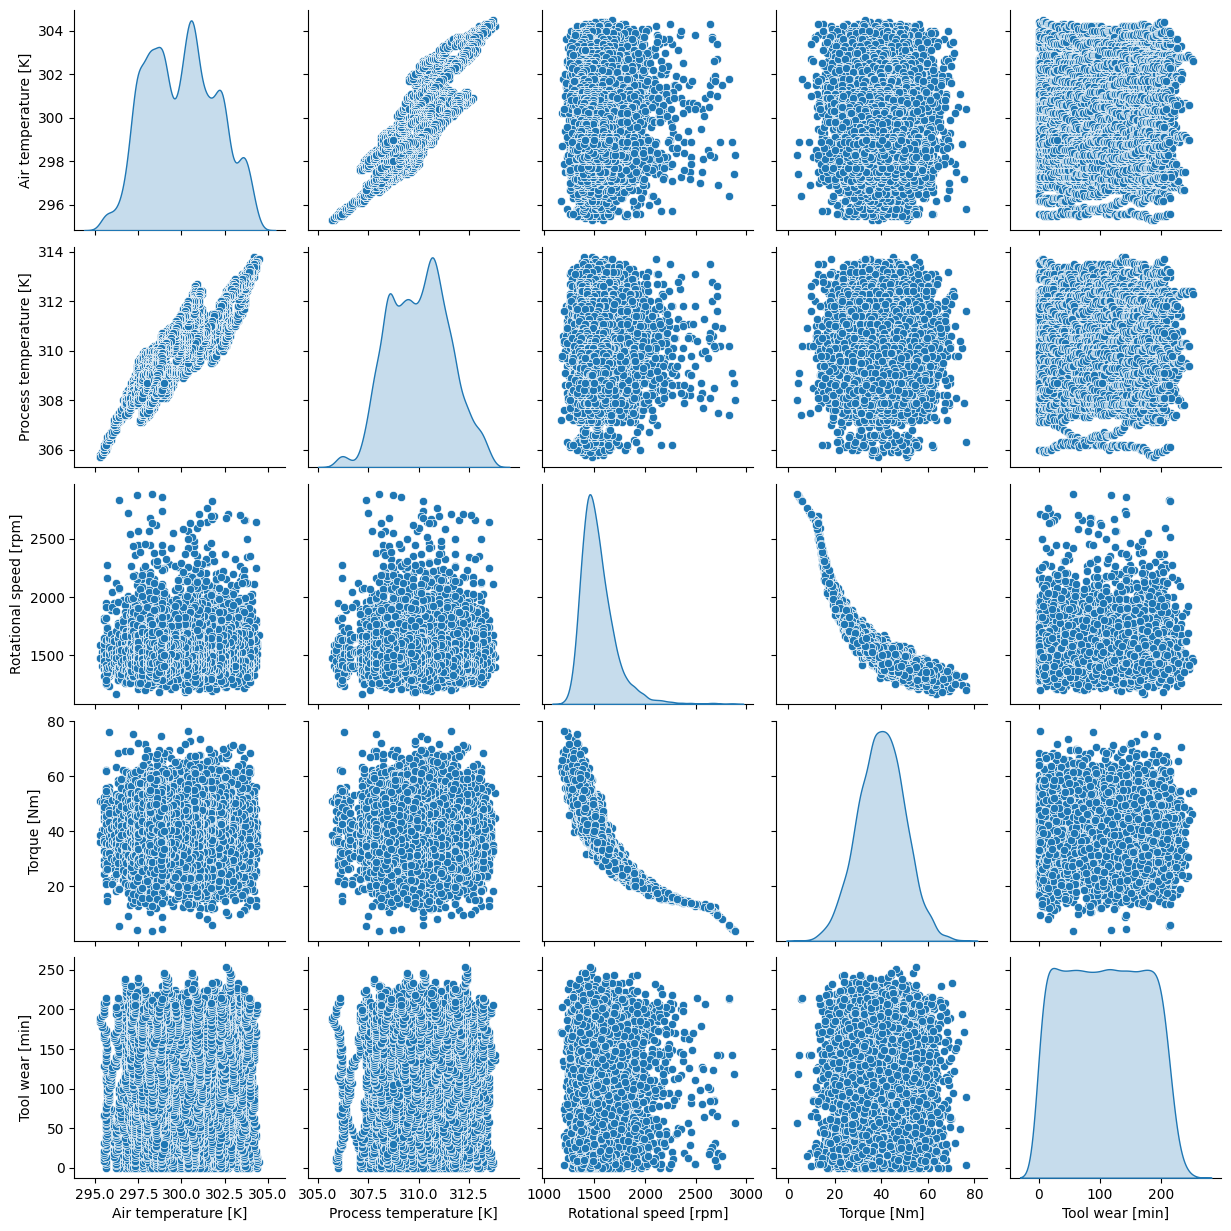

In [ ]:
# Isolating just the relevant numeric columns to slam through a correlation matrix
mtnc_corr_df = maintenance_df[["Air temperature [K]", "Process temperature [K]","Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]" ]].corr()

print(mtnc_corr_df)
# Doing my best to make some pretty graphs
plt.figure(figsize=(5,5))
plt.title("Correlation Matrix",fontsize = 14, fontweight ="bold")
sns.heatmap(mtnc_corr_df, cmap="vlag",  fmt=".2f", linewidths=0.5)
sns.pairplot(maintenance_df[["Air temperature [K]", "Process temperature [K]","Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]" ]], diag_kind = "kde")

### Correlation Matrix & Pair Plot Analysis:

The above correlation matrix and pair plots show interesting relationships, and more interestingly, the lack of relationships between many of the input variables. Many of these correlations are understandable via the physics equations governing them. 

The strong correlation between Air Temperature and Process Temperature makes sense because, the temperature inside the process and the temperature around the process are interacting via heat transfer. Simililarly, the inverse relationship between torque and rotational speed makes sense because physical systems are governed via: 

$P = \tau / \omega  $ 
                
Where P is power, Tau is torque and Omega is rotational velocity. This means that for a given input power, an increase in speed would cause a decrease in torque and vis-versa.

The lack of correlation elsewhere is likely a good sign. Given what is known about about the physical system that this data came from, any other correlations would be unexpected and require significant investigation.

In [72]:
# I want to better understand the failure rate of the dataset being used. Because a 1 for Target indicates failure and it's a 0 otherwise, the mean is the percentage of failures seen in the dataset
print(maintenance_df['Target'].describe())

count    10000.000000
mean         0.033900
std          0.180981
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Target, dtype: float64


### Considerations for distributions of failures:

One of the potential pitfalls with classification of predicative maintenance data is that failures tend to be underrepresented in the datasets available. As shown above, failures only represent 3.4% of the data in the dataset. Instinctively this makes sense as most things work most of the time, e.g. its not a 50-50 chance that a car starts when someone turns the it on, failures are a small part of the population. This means that test train splits that use random selection could accidentally include almost zero failure cases if the randomized distribution falls in a disadventageous manner. This will have to be verified for all model building to follow.

The highly imballanced nature of the outcomes also means that the AUC-ROC curve could give misleading results when grading the models. As such, I will instead be using the Precision-Recall curve in order to evaluate the performance of the models.

Depending on the business context, false negatives can be incredibly expensive occurences. I have worked at companies where unplanned maintenance has cost millions of dollars a year in lost production. As such, it is important that the model have an incredibly strong Recall performance. Depending on the precise dollar amount of the cost of machine downtime, it is sometimes advantageous to accept a much higher false positive rate, for a slight reduction in false negatives. That sort of economic analysis is important to note, but beyond the scope of this report as I do not have any actual business data to use.

### Test Train Split and Predictor Selection

I will be using a fairly standard 20-80 test-train split for the data, using inbuult sklearn split tooling.

I will be dropping UDI, Product ID, Type, and Failure Type from the training data. With the exception of UDI, they are categorical, not numeric. Considering their impacts would be good for a follow on analysis.

I'm going to be removing Air temperature and Rotational speed from the model. Air temperature has a very high Pearson correlation to Process temperature. From a mechanical engineering perspective, process temperature is more relevant to overall performance so it is what will be kept.

I will also be removing rotational speed. It is also shown to have a large absolute Pearson correlation with Torque.

Removing these highly correlated predictors will allow for better models.

In [73]:
# Setting up my test train split, will be using this split to evaluate all following models
x = maintenance_df[["Process temperature [K]", "Torque [Nm]", "Tool wear [min]"]]
y = maintenance_df["Target"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


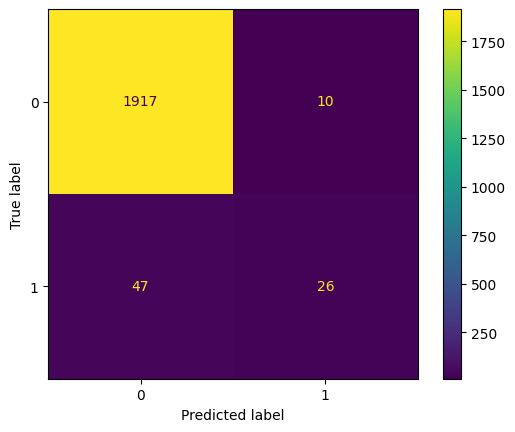

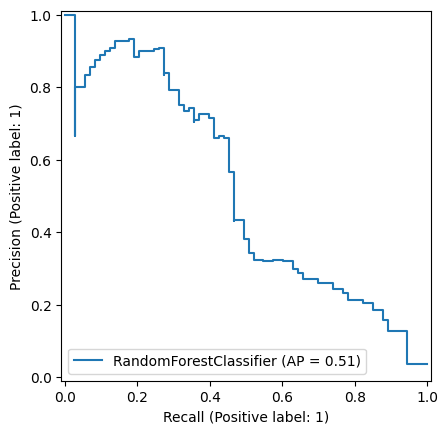

In [74]:
# Building initial random forest model
rf_model = RandomForestClassifier().fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test)
plt.show()

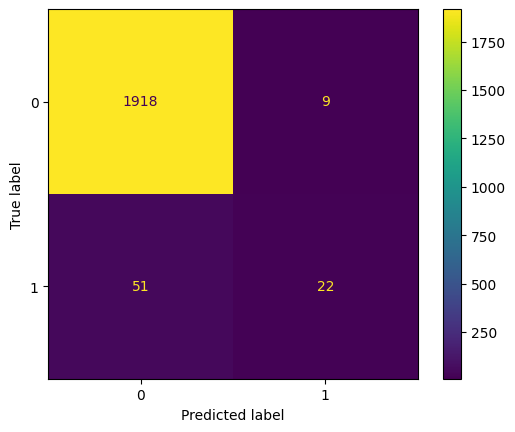

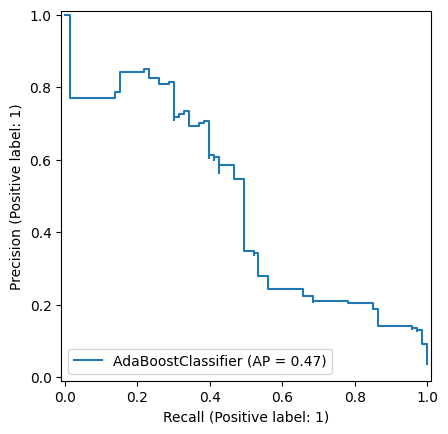

In [75]:
# Buidling intiial adaboost model
ada_model = AdaBoostClassifier().fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(ada_model, X_test, y_test)
PrecisionRecallDisplay.from_estimator(ada_model, X_test, y_test)
plt.show()

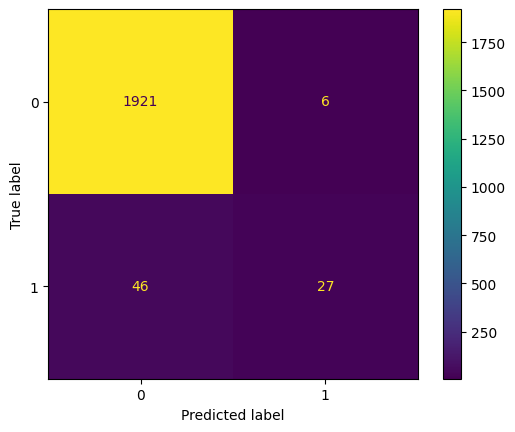

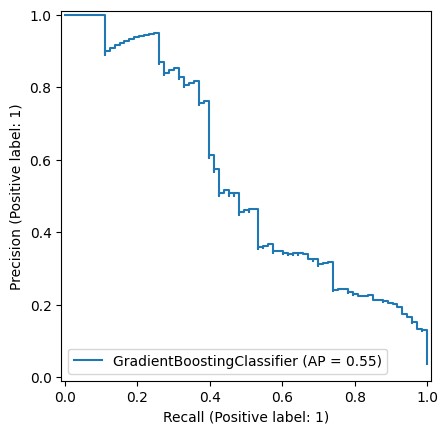

In [76]:
# Building initial gradient boost model
gradient_model = GradientBoostingClassifier().fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(gradient_model, X_test, y_test)
PrecisionRecallDisplay.from_estimator(gradient_model, X_test, y_test)
plt.show()

### Intial Results:

The initial results of these models are not promising. They all struggled to accurately identify true positives as seen in the correlation matrix. The Precision - Recall curve performance is also far below acceptable for all models used.  

In a real world application, this is where I, as a test engineer, would go back and run more testing to gather a larger population of data and also potentially distill or sample the data in order for the positive occurences to be more largely represented in the dataset. 

I will now attempt to tune the parameters for the gradient boost model using grid search.

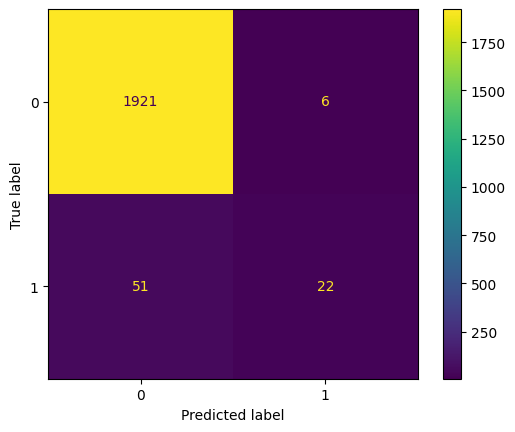

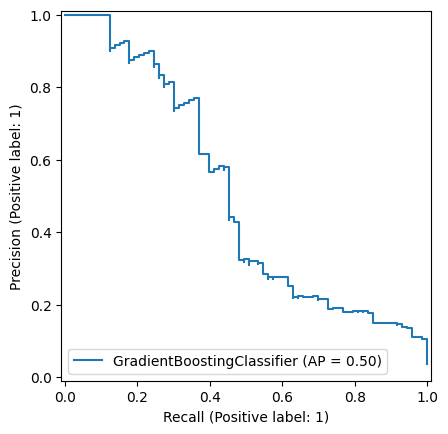

In [77]:

# This is the grid search parameters I will be using to try to refine my gradient boosted model 
param_grid = {
    'n_estimators': [100, 200],  
    'learning_rate': [0.01, 0.1],  
    'max_depth': [3, 4],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],
}

# Setting up a 5 fold cv grid search
grid_search = GridSearchCV(estimator=gradient_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Extracting the best model from the grid search for use
best_gradient_model = grid_search.best_estimator_

ConfusionMatrixDisplay.from_estimator(best_gradient_model, X_test, y_test)
PrecisionRecallDisplay.from_estimator(best_gradient_model, X_test, y_test)
plt.show()




#### Grid Search Results:

Grid search has not shown a significant improvement in the performance of the gradient boost model. Actually, from a precision - recall perspective, the model now performs worse. This is likely due to the limited grid I have provided to be searched. Larger grids would be too computationally intensive for me to run on my laptop. The current search takes over a minute as is. I made a best guess at some of the inital grid values based on what some reading of the sklearn docs. Clearly that isn't enough. This is a good spot for follow on analysis to improve the model performance.

#### Dealing with the data imbalance:

The performance issues with the models above mainly come down to highly imbalanced nature of the training dataset. I will attempt to rectify this using a method called SMOTE.

SMOTE rebalances the training population by creating synthetic entrys for the minority case. For this application, the minority case is a failure occuring.

In [78]:
# Setting up smote to sample my data and create a new balanaced set

smote = SMOTE(sampling_strategy='auto', random_state=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


##### Rerunning all the models with the new smote data:

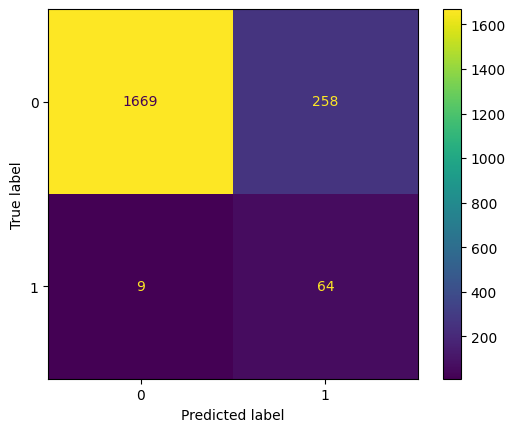

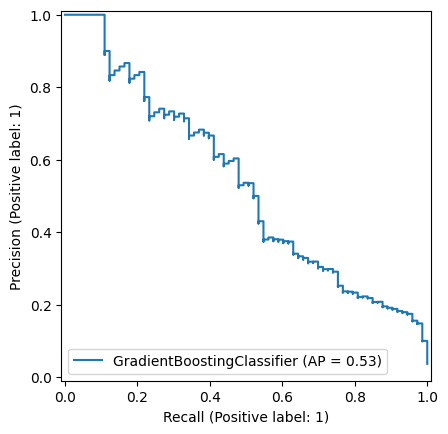

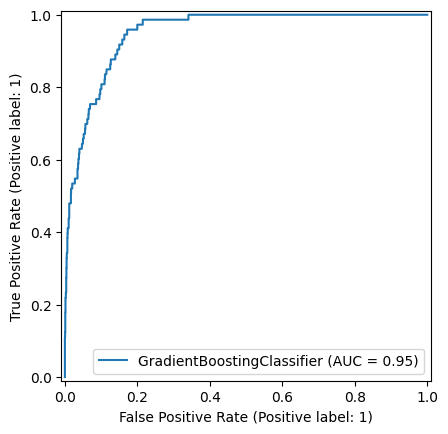

In [79]:
gradient_model = GradientBoostingClassifier().fit(X_train_smote, y_train_smote)
ConfusionMatrixDisplay.from_estimator(gradient_model, X_test, y_test)
PrecisionRecallDisplay.from_estimator(gradient_model, X_test, y_test)
RocCurveDisplay.from_estimator(gradient_model,X_test, y_test)
plt.show()

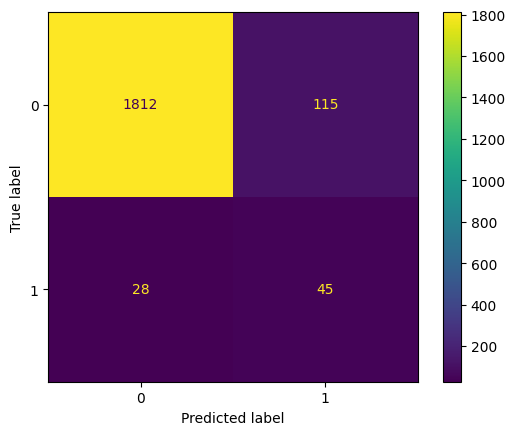

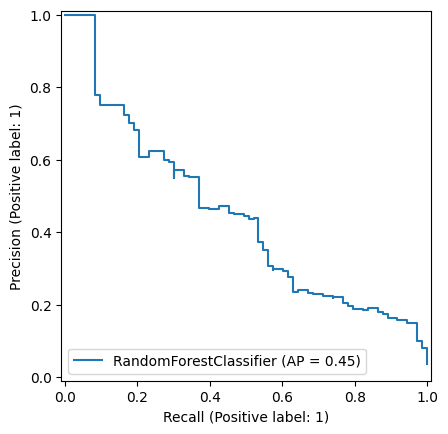

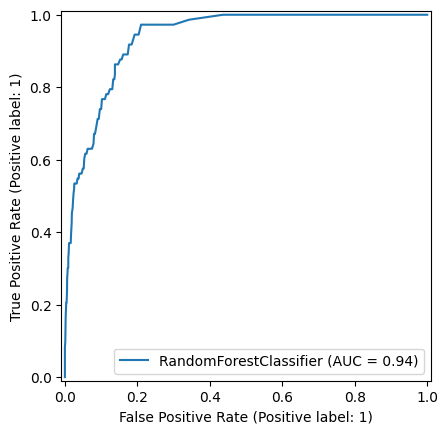

In [80]:
rf_model = RandomForestClassifier().fit(X_train_smote, y_train_smote)
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test)
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.show()

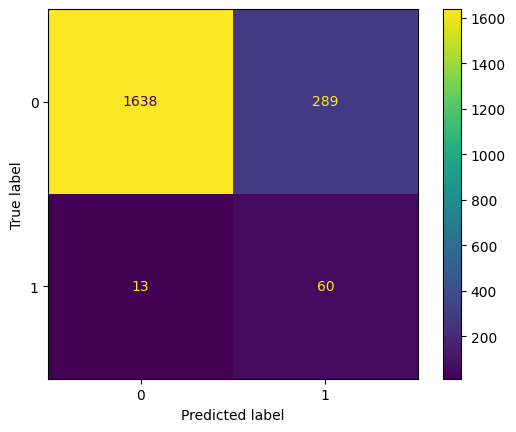

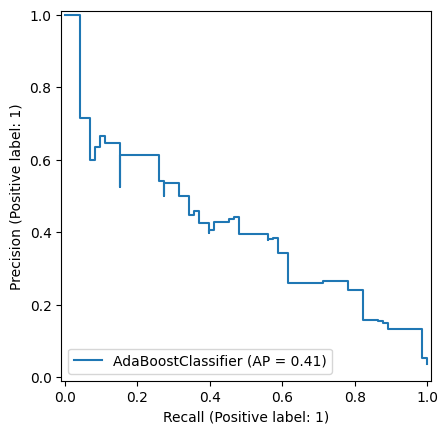

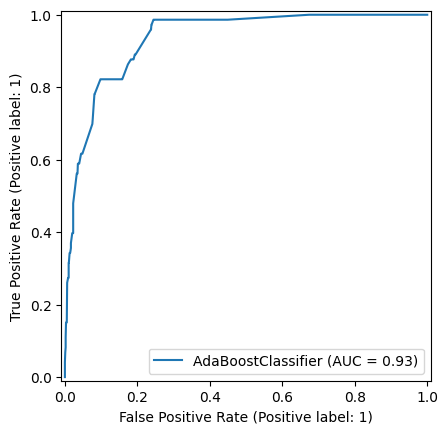

In [81]:
ada_model = AdaBoostClassifier().fit(X_train_smote, y_train_smote)
ConfusionMatrixDisplay.from_estimator(ada_model, X_test, y_test)
PrecisionRecallDisplay.from_estimator(ada_model, X_test, y_test)
RocCurveDisplay.from_estimator(ada_model, X_test, y_test)
plt.show()

### Conclusions:

#### Key Takeaways
After using SMOTE to rebalance the data and retraining the models, there are still significant performance dificiencies, but the gradient boost model is now at a point where it likely can be successfully used in production. 

All models have acceptabled final AUC values that are above 0.9. This is less important than the Precision - Recall curve due to the imbalanced nature of the outcomes in the dataset. The precision recall curves for all the final models are lower than 0.6. This would indicate poor performance at detecting anomalous machine failures. Despite this, looking at the confusion matrix, it accurately predicted 60 of the 73 false. It had a large amount of false positives at 289 but depending on the cost to the business of the failure of the machine, that may be an acceptable outcome. 

As such, the gradient boost model may be acceptable for use in production environments where the cost of machine breakdown is so high, that an overwelming amount of false positive predictions is acceptable.

#### What Didn't Work:

As I talked about in the grid search section, grid search on the gradient boost model did not yield the performance improvements I had hoped it would. This likely comes down to bad selection of paramater ranges for the search terms. This can be improved via further reading and understanding of the gradient boost model in order to better choose the parameter ranges to be searched over. This could also be improved via more compute power being applied to the problem, allowing for a vastly expanded search radius.

#### What can be improved:

1. Better hyperparameter tuning: With more compute power, and a better starting grid, grid search can likely produce a much better model than the current one.
2. Different Model Selection: SVM and Logistic regression models, with properly normalized data, would potentially be another avenue for increased model performance. This analysis was only focused on various types of decision trees.
3. Gathering a larger population of data: Conducting more testing on the machines producing the data and observing more failures would yield a larger overall dataset that could unlock better performance.